<>:752: SyntaxWarning: invalid escape sequence '\s'
<>:752: SyntaxWarning: invalid escape sequence '\s'
C:\Users\mahd\AppData\Local\Temp\ipykernel_18876\4057496143.py:752: SyntaxWarning: invalid escape sequence '\s'
  "1$\sigma$, 2$\sigma$ and 3$\sigma$ Dispersion Ellipses: Apogee and Landing Points"
C:\Users\mahd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'weather.uwyo.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


'Completed 4 iterations successfully. Total CPU time: 5.546875 s. Total wall time: 12.181230545043945 s'

Number of simulations:  4



BELOW IS FROM SPACEPORT LAUNCH SITE



Apogee Altitude -         Mean Value: 3152.863 m
Apogee Altitude - Standard Deviation: 47.519 m
3089.1450771663713
3201.2488847150084
50
2.2420761509727436


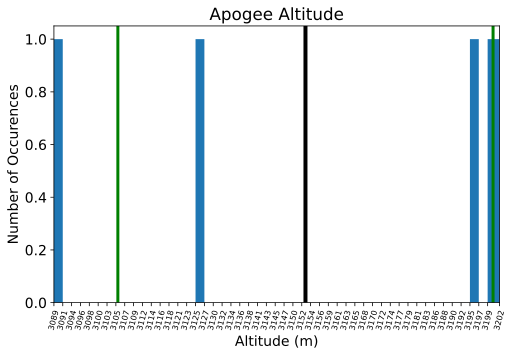

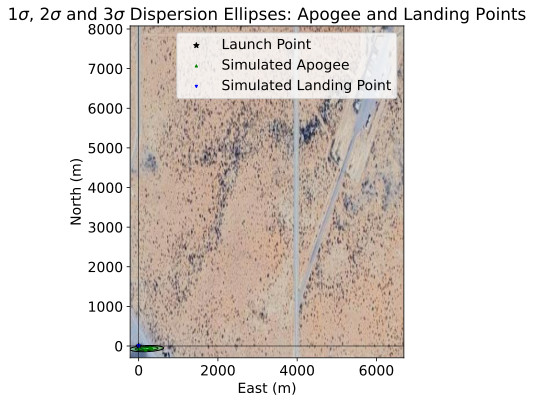




AVERAGE TRAJECTORY FOR FLIGHTS WITH WEATHER FILE 1:





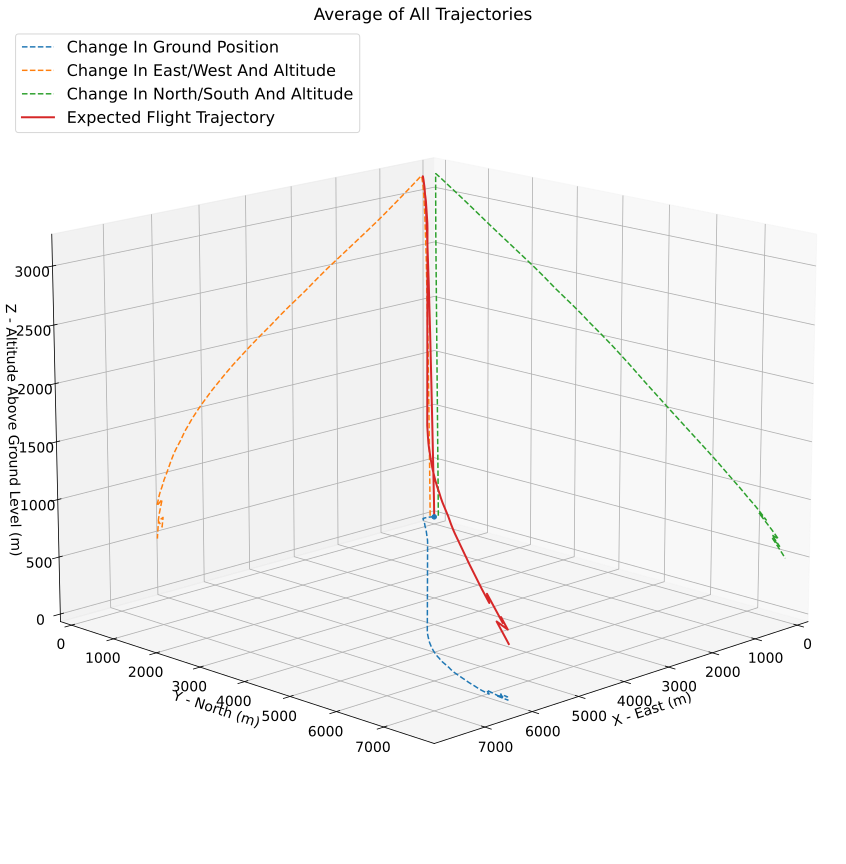




AVERAGE TRAJECTORY FOR SPACEPORT FLIGHTS





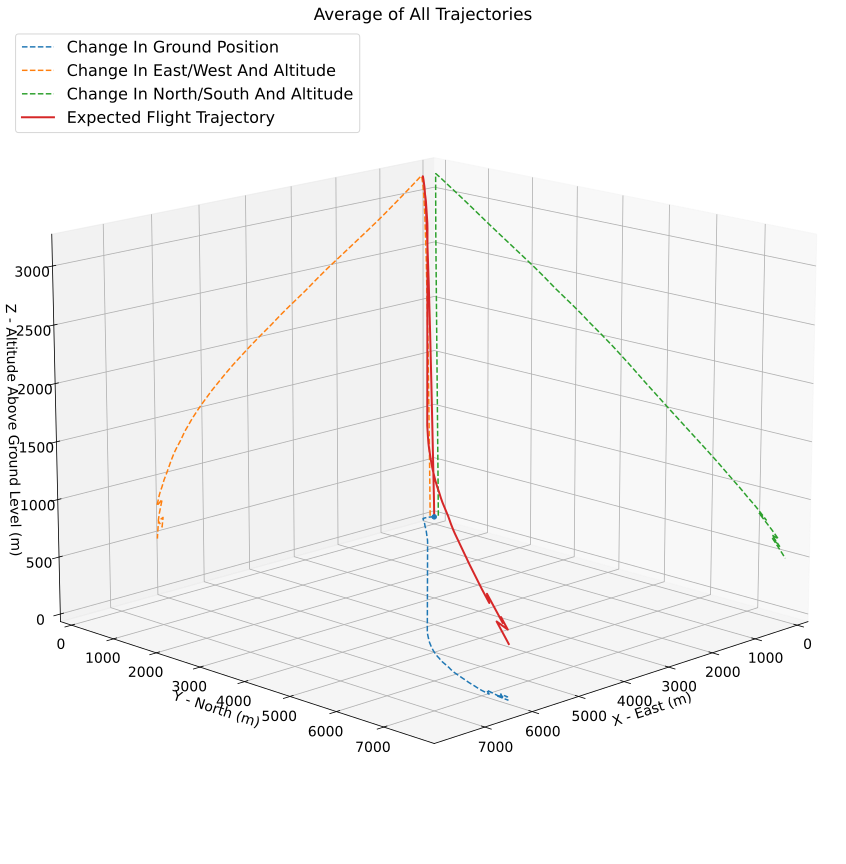

In [16]:
from rocketpy import Environment, SolidMotor, Rocket, Flight

from time import process_time, time

import matplotlib  as mpl
import matplotlib.pyplot as plt
from IPython.display import display

import imageio.v2 as imageio
from matplotlib.patches import Ellipse

import ssl
import certifi

%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt

from rocketpy.plots import flight_plots

%matplotlib inline
mpl.rcParams["figure.figsize"] = [8, 5]
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.titlesize"] = 14

import numpy as np
from numpy.random import normal, choice

import openpyxl

# Define variable to load the dataframe
dataframe = openpyxl.load_workbook("WeatherData.xlsx")

# Define variable to read sheet
dataframe1 = dataframe.active

# Iterate the loop to read the cell values

env = Environment(latitude=0, longitude=0, elevation = 0)

import datetime

tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))  # Hour given in UTC time
env.set_atmospheric_model(type="Forecast", file = "GFS")
# env.info()

dryMass = 4.76135911
grainInner =(39.37*10**-3)/2
grainOuter =(82.27*10**-3)/2
density = dryMass / ((np.pi*grainOuter**2)-(np.pi*grainInner**2))
grainHeight = 0.1524
numGrain = 5
totalHeight = grainHeight*numGrain
centralAxis = (0.08333)*dryMass*(grainOuter)**2
centralDiameter = ((1/4)*dryMass*(grainOuter)**2) + (1/12)*dryMass*(totalHeight)**2

MotorOne = SolidMotor(
    thrust_source= "thrustcurve.csv",
    dry_mass= dryMass,
    dry_inertia= (centralAxis,centralAxis,centralDiameter),
    nozzle_radius= (79.32*10**-3)/2 ,
    grain_number= numGrain,
    grain_density= density,
    grain_outer_radius= grainOuter ,
    grain_initial_inner_radius= grainInner,
    grain_initial_height= grainHeight,
    grain_separation= 0,
    grains_center_of_mass_position= 0,
    center_of_dry_mass_position= 0,
    nozzle_position= grainHeight*3.3,
    burn_time= 2.14,
    throat_radius= (29.21*10**-3)/2,
    coordinate_system_orientation="combustion_chamber_to_nozzle",
)

# M1850W.all_info()

#Pretty Much done except grain density and maybe nozzle position

spMass = 16.4
spRadius = 0.155/2
spLength = 3.05

spCentralAxis = (1/12)*spMass*(spRadius)**2
spCentralDiameter = ((1/4)*spMass*(spRadius)**2) + (1/12)*spMass*(spLength)**2

Sp25 = Rocket(
    mass = spMass,
    radius = spRadius,
    inertia = (spCentralDiameter,spCentralDiameter,spCentralAxis), # Calculated via Open Rocket
    coordinate_system_orientation = "nose_to_tail",
    center_of_mass_without_motor = 1.64 , #OpenRocket
    power_off_drag ="Sp25CDOFF10.7.csv", #RAS Aero
    power_on_drag ="Sp25CDON10.7.csv"
)

Sp25.add_motor(MotorOne,3.05-(0.762/2)+0.241-0.203/2)

nose_cone = Sp25.add_nose(length = 0.914, kind = "von karman", position = 0)

fin_set = Sp25.add_trapezoidal_fins(n=4,root_chord=0.279,tip_chord=0.091, span=0.146,position=2.67,cant_angle=0,sweep_length=0.173)

boattail = Sp25.add_tail(top_radius = spRadius,bottom_radius = 0.127/2,length = 0.203,position = spLength)

rail_buttons = Sp25.set_rail_buttons(
    upper_button_position= 1.57+0.444,
    lower_button_position= 1.57+0.888,
    angular_position=135
)
drogueRadius = 0.61/2

Drogue = Sp25.add_parachute(
    "Drogue",
    cd_s = 0.97*3.1416*(drogueRadius)**2,
    trigger = "apogee"
)
lightRadius = 3.05/2
Light = Sp25.add_parachute(
    "Light",
    cd_s = 2.2*3.1415*(lightRadius)**2,
    trigger = 549
)

test_flight = Flight(
    rocket=Sp25, environment=env ,rail_length = 4.572,inclination = 88,heading =90
)

analysis_parameters = {
    # Rocket's dry mass without motor (kg) and its uncertainty (standard deviation)
    "rocket_mass": (Sp25.mass, 0.001),
    # Rocket's inertia moment perpendicular to its axis (kg*m^2)
    "rocket_inertia_11": (Sp25.I_11_without_motor, 0.036),
    # Rocket's inertia moment relative to its axis (kg*m^2)
    "rocket_inertia_33": (Sp25.I_33_without_motor, 0.00001),
    # Motors's dry mass without propellant (kg) and its uncertainty (standard deviation)
    "motor_dry_mass": (MotorOne.dry_mass, 0.001),
    # Motor's dry inertia moment perpendicular to its axis (kg*m^2)
    "motor_inertia_11": (MotorOne.dry_I_11, 0.016),
    # Motors's dry inertia moment relative to its axis (kg*m^2)
    "motor_inertia_33": (MotorOne.dry_I_33, 0.00001),
    # Distance between rocket's center of dry mass and motor's center of dry mass (m)

    # THIS is likely wrong, go back to check it

    "motor_dry_mass_position": (Sp25.motor_center_of_dry_mass_position, 0.001),
    # Motor total impulse (N*s)
    "impulse": (7658.6, 25.3),
    # Motor burn out time (s)
    "burn_time": (MotorOne.burn_time[1], .3),
    # Motor's nozzle radius (m)
    "nozzle_radius": (MotorOne.nozzle_radius, 0.5 / 1000),
    # Motor's nozzle throat radius (m)
    "throat_radius": (MotorOne.throat_radius, 0.5 / 1000),
    # Motor's grain separation (axial distance between two grains) (m)
    "grain_separation": (MotorOne.grain_separation, 1 / 1000),
    # Motor's grain density (kg/m^3)
    "grain_density": (MotorOne.grain_density, 20),
    # Motor's grain outer radius (m)
    "grain_outer_radius": (MotorOne.grain_outer_radius, 0.3 / 1000),
    # Motor's grain inner radius (m)
    "grain_initial_inner_radius": (MotorOne.grain_initial_inner_radius, 0.3 / 1000),
    # Motor's grain height (m)
    "grain_initial_height": (MotorOne.grain_initial_height, 1 / 1000),
    # Rocket's radius (kg*m^2)
    "radius": (Sp25.radius, 0.001),
    # Distance between rocket's center of dry mass and nozzle exit plane (m) (negative)
    "nozzle_position": (Sp25.nozzle_position, 0.001),
    # Distance between rocket's center of dry mass and and center of propellant mass (m) (negative)
    "grains_center_of_mass_position": (Sp25.center_of_dry_mass_position-(1.64 + 83.44 / 1000 * 3.5), 0.0001),

    # Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    "power_off_drag": (1, 0.05),
    # Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    "power_on_drag": (1, 0.05),
    # Rocket's nose cone length (m)
    "nose_length": (nose_cone.length, 0.001),
    # Axial distance between rocket's center of dry mass and nearest point in its nose cone (m)
    "nose_distance_to_CM": (Sp25.center_of_dry_mass_position-nose_cone.length, 0.001),
    # Fin span (m)
    "fin_span": (fin_set.span, 0.0001),
    # Fin root chord (m)
    "fin_root_chord": (fin_set.root_chord, 0.0001),
    # Fin tip chord (m)
    "fin_tip_chord": (fin_set.tip_chord, 0.0001),
    # Axial distance between rocket's center of dry mass and nearest point in its fin (m)
    "fin_distance_to_CM": (2.67 - Sp25.center_of_dry_mass_position, 0.001),
    # Launch rail inclination angle relative to the horizontal plane (degrees)
    "inclination": (test_flight.inclination, 1),
    # Launch rail heading relative to north (degrees)
    "heading": (test_flight.heading, 2),
    # Launch rail length (m)
    "rail_length": (test_flight.rail_length, 0.0005),
    # Drag coefficient times reference area for the drogue chute (m^2)
    "cd_s_drogue": (Drogue.cd_s, 0.02),
    # Time delay between parachute ejection signal is detected and parachute is inflated (s)
    "lag_rec": (Drogue.lag, 0.2),
    # Time delay between sensor signal is received and ejection signal is fired (s)
    "lag_se": (Drogue.lag, 0.1),
}

def flight_settings(analysis_parameters, total_number):
    i = 0
    while i < total_number:
        # Generate a flight setting
        flight_setting = {}
        for parameter_key, parameter_value in analysis_parameters.items():
            if type(parameter_value) is tuple:
                flight_setting[parameter_key] = normal(*parameter_value)
            else:
                flight_setting[parameter_key] = choice(parameter_value)

        # Skip if certain values are negative, which happens due to the normal curve but isnt realistic
        if flight_setting["lag_rec"] < 0 or flight_setting["lag_se"] < 0:
            continue

        # Update counter
        i += 1
        # Yield a flight setting
        yield flight_setting

def export_flight_data(flight_setting, flight_data, exec_time):
    # Generate flight results
    flight_result = {
        "out_of_rail_time": flight_data.out_of_rail_time,
        "out_of_rail_velocity": flight_data.out_of_rail_velocity,
        "max_velocity": flight_data.speed.max,
        "apogee_time": flight_data.apogee_time,
        "apogee_altitude": flight_data.apogee - env.elevation,
        "apogee_x": flight_data.apogee_x,
        "apogee_y": flight_data.apogee_y,
        "impact_time": flight_data.t_final,
        "impact_x": flight_data.x_impact,
        "impact_y": flight_data.y_impact,
        "impact_velocity": flight_data.impact_velocity,
        "initial_static_margin": flight_data.rocket.static_margin(0),
        "out_of_rail_static_margin": flight_data.rocket.static_margin(
            flight_data.out_of_rail_time
        ),
        "final_static_margin": flight_data.rocket.static_margin(
            flight_data.rocket.motor.burn_out_time
        ),
        "number_of_events": len(flight_data.parachute_events),
        "execution_time": exec_time,
    }

    # Take care of parachute results
    if len(flight_data.parachute_events) > 0:
        flight_result["drogue_triggerTime"] = flight_data.parachute_events[0][0]
        flight_result["drogue_inflated_time"] = (
            flight_data.parachute_events[0][0] + flight_data.parachute_events[0][1].lag
        )
        flight_result["drogue_inflated_velocity"] = flight_data.speed(
            flight_data.parachute_events[0][0] + flight_data.parachute_events[0][1].lag
        )
    else:
        flight_result["drogue_triggerTime"] = 0
        flight_result["drogue_inflated_time"] = 0
        flight_result["drogue_inflated_velocity"] = 0

    # Write flight setting and results to file
    MonteCarloInputFile.write(str(flight_setting) + "\n")
    MonteCarloOutputFile.write(str(flight_result) + "\n")


def export_flight_error(flight_setting):
    MonteCarloErrorFile.write(str(flight_setting) + "\n")

flights = list()
env = Environment(latitude=32.9823279, longitude=-106.9490122, elevation = 1400.556)
currentRow = 1
# SP.all_info()
# M1850W.all_info()
for row in dataframe1.iter_rows(1, dataframe1.max_row):
        flightForCurrent = list()
        if currentRow > 2:
            env = Environment(latitude=33.4984104, longitude=-99.3353701, elevation = 18)
        if row[0].value.find("noaa") == -1:
            env.set_atmospheric_model(type="wyoming_sounding", file = row[0].value)
        else:
            env.set_atmospheric_model(type="NOAARucSounding", file = row[0].value)
        # env.all_info()
        # Create data files for inputs, outputs and error logging
        i = 0
        filename = "MonteCarlo" + str(currentRow)
        number_of_simulations = 4
        MonteCarloErrorFile = open(str(filename) + ".Errors.txt", "w")
        MonteCarloInputFile = open(str(filename) + ".Input.txt", "w")
        MonteCarloOutputFile = open(str(filename) + ".Output.txt", "w")

        initial_wall_time = time()
        initial_cpu_time = process_time()
        # Iterate over flight settings
        out = display("Starting", display_id=True)
        for setting in flight_settings(analysis_parameters, number_of_simulations):
            start_time = process_time()
            i += 1

            MotorOne = SolidMotor(
                thrust_source="AeroTech_M1850W.eng", #Thrustcurve.org Mike Haberer - Rock Sim, Also uploaded to Google
                burn_time= 2.14,#Straight from thrustcurve.org
                reshape_thrust_curve=(setting["burn_time"], setting["impulse"]),
                nozzle_radius= setting["nozzle_radius"], # Part List
                throat_radius= setting["throat_radius"], # Part List
                grain_number=numGrain, #Based on cross-section
                grain_separation= setting["grain_separation"], # Good
                grain_density= setting["grain_density"], #Calculated mass of grain / volume of grain , for this i did - the core since it should be empty? not sure
                grain_outer_radius= setting["grain_outer_radius"], # Good
                grain_initial_inner_radius= setting["grain_initial_inner_radius"], # Good
                grain_initial_height= setting["grain_initial_height"] , # Good
                interpolation_method = "linear",
                coordinate_system_orientation="combustion_chamber_to_nozzle",
                nozzle_position = setting["nozzle_position"] - 3.05-(0.762/2)+0.241-0.203/2,#eyeballed
                grains_center_of_mass_position= 0,
                dry_mass=setting["motor_dry_mass"], #kg thrustcurve
                dry_inertia=(setting["motor_inertia_11"], setting["motor_inertia_11"], setting["motor_inertia_33"]), #based off drawing
                center_of_dry_mass_position= 0,
            )

            #Pretty Much done except grain density and maybe nozz)le position


            Sp25 = Rocket(
                mass = setting["rocket_mass"], #OpenRocket
                radius = setting["radius"], #OpenRocket
                inertia = (setting["rocket_inertia_11"], setting["rocket_inertia_11"],setting["rocket_inertia_33"]), # Calculated via Open Rocket
                coordinate_system_orientation = "nose_to_tail",
                center_of_mass_without_motor = 1.64, # OpenRocket
                power_off_drag ="CD_OFF_L3_Rocket.csv", #Uploaded to drive
                power_on_drag = "CD_ON_L3_Rocket.csv", #Uploaded to drive
            )

            Sp25.power_off_drag *= setting["power_off_drag"]
            Sp25.power_on_drag *= setting["power_on_drag"]

            Sp25.add_motor(MotorOne, 2.4225)


            nose_cone = Sp25.add_nose(
                length = setting["nose_length"], kind = "lvhaack", position = 0)

            fin_set = Sp25.add_trapezoidal_fins(n=3, root_chord= setting["fin_root_chord"], tip_chord=setting["fin_tip_chord"], span=setting["fin_span"],position=setting["fin_distance_to_CM"] + Sp25.center_of_dry_mass_position,cant_angle=0, sweep_length=0.173)

            rail_buttons = Sp25.set_rail_buttons(
                upper_button_position=1.57+0.444,
                lower_button_position=1.57+0.888,
                angular_position=135
            )

            Drogue = Sp25.add_parachute(
                "Drogue",
                cd_s = setting["cd_s_drogue"],
                trigger = "apogee"
            )
            Light = Sp25.add_parachute(
                "Light",
                cd_s = 2.2*3.1415*(lightRadius)**2,
                trigger = "apogee"
            )

            # Run trajectory simulation
            try:
                testFlight = Flight(
                    rocket=Sp25, environment=env,rail_length = setting["rail_length"],inclination = setting["inclination"],heading=setting["heading"],
                )
                flights.append(testFlight)
                flightForCurrent.append(testFlight)
                export_flight_data(setting, testFlight, process_time() - start_time)
            except Exception as E:
                print(E)
                export_flight_error(setting)

            # Register time
            out.update(
                f"Curent iteration: {i:06d} | Average Time per Iteration: {(process_time() - initial_cpu_time)/i:2.6f} s"
            )

        # Done

        ## Print and save total time
        final_string = f"Completed {i} iterations successfully. Total CPU time: {process_time() - initial_cpu_time} s. Total wall time: {time() - initial_wall_time} s"
        out.update(final_string)
        MonteCarloInputFile.write(final_string + "\n")
        MonteCarloOutputFile.write(final_string + "\n")
        MonteCarloErrorFile.write(final_string + "\n")

        ## Close files
        MonteCarloInputFile.close()
        MonteCarloOutputFile.close()
        MonteCarloErrorFile.close()

        # Initialize variable to store all results
        dispersion_general_results = []

        dispersion_results = {
            "out_of_rail_time": [],
            "out_of_rail_velocity": [],
            "apogee_time": [],
            "apogee_altitude": [],
            "apogee_x": [],
            "apogee_y": [],
            "impact_time": [],
            "impact_x": [],
            "impact_y": [],
            "impact_velocity": [],
            "initial_static_margin": [],
            "out_of_rail_static_margin": [],
            "final_static_margin": [],
            "number_of_events": [],
            "max_velocity": [],
            "drogue_triggerTime": [],
            "drogue_inflated_time": [],
            "drogue_inflated_velocity": [],
            "execution_time": [],
        }

        # Get all dispersion results
        # Get file
        dispersion_output_file = open(str(filename) + ".Output.txt", "r+")

        # Read each line of the file and convert to dict
        for line in dispersion_output_file:
            # Skip comments lines
            if line[0] != "{":
                continue
            # Eval results and store them
            flight_result = eval(line)
            dispersion_general_results.append(flight_result)
            for parameter_key, parameter_value in flight_result.items():
                dispersion_results[parameter_key].append(parameter_value)

        # Close data file
        dispersion_output_file.close()

        # Print number of flights simulated
        N = len(dispersion_general_results)
        print("Number of simulations: ", N)

        if currentRow <= 2:
            img = plt.imread("SpaceportLaunchSite.png")
            print("\n\n\nBELOW IS FROM SPACEPORT LAUNCH SITE\n\n\n")
        else:
            img = plt.imread("SeymourLaunchSite.png")
            print("\n\n\nBELOW IS FROM SEYMOUR LAUNCH SITE\n\n\n")
        # Import background map


        # Retrieve dispersion data por apogee and impact XY position
        apogee_x = np.array(dispersion_results["apogee_x"])
        apogee_y = np.array(dispersion_results["apogee_y"])
        impact_x = np.array(dispersion_results["impact_x"])
        impact_y = np.array(dispersion_results["impact_y"])


        # Define function to calculate eigen values
        def eigsorted(cov):
            vals, vecs = np.linalg.eigh(cov)
            order = vals.argsort()[::-1]
            return vals[order], vecs[:, order]

        # print(
        #     f'Out of Rail Time -         Mean Value: {np.mean(dispersion_results["out_of_rail_time"]):0.3f} s'
        # )
        # print(
        #     f'Out of Rail Time - Standard Deviation: {np.std(dispersion_results["out_of_rail_time"]):0.3f} s'
        # )

        # plt.figure()
        # plt.hist(dispersion_results["out_of_rail_time"], bins=int(N**0.5))
        # plt.title("Out of Rail Time")
        # plt.xlabel("Time (s)")
        # plt.ylabel("Number of Occurences")
        # plt.show()

        # print(
        #     f'Out of Rail Velocity -         Mean Value: {np.mean(dispersion_results["out_of_rail_velocity"]):0.3f} m/s'
        # )
        # print(
        #     f'Out of Rail Velocity - Standard Deviation: {np.std(dispersion_results["out_of_rail_velocity"]):0.3f} m/s'
        # )

        # plt.figure()
        # plt.hist(dispersion_results["out_of_rail_velocity"], bins=int(N**0.5))
        # plt.title("Out of Rail Velocity")
        # plt.xlabel("Velocity (m/s)")
        # plt.ylabel("Number of Occurences")
        # plt.show()

        # print(
        #     f'Apogee Time -         Mean Value: {np.mean(dispersion_results["apogee_time"]):0.3f} s'
        # )
        # print(
        #     f'Apogee Time - Standard Deviation: {np.std(dispersion_results["apogee_time"]):0.3f} s'
        # )

        # plt.figure()
        # plt.hist(dispersion_results["apogee_time"], bins=int(N**0.5))
        # plt.title("Apogee Time")
        # plt.xlabel("Time (s)")
        # plt.ylabel("Number of Occurences")
        # plt.show()
        mean = np.mean(dispersion_results["apogee_altitude"])
        deviation = np.std(dispersion_results["apogee_altitude"])
        print(
            f'Apogee Altitude -         Mean Value: {mean:0.3f} m'
        )
        print(
            f'Apogee Altitude - Standard Deviation: {deviation:0.3f} m'
        )

        minimum = np.min(dispersion_results["apogee_altitude"])
        print(minimum)
        maximum = np.max(dispersion_results["apogee_altitude"])
        print(maximum)
        theBins = list()

        #using scott's rule to find the number of bins
        binWidth = 3.5 * deviation / np.power(len(dispersion_results["apogee_altitude"]), 1/3)
        numBins = int(np.round((maximum-minimum)/binWidth))
        print(numBins)
        changeInZ = (maximum - minimum) / numBins
        print(changeInZ)
        #test add
        zIterator = minimum
        for iterator in range(numBins):
            theBins.append(zIterator)
            zIterator += changeInZ
        theBins.append(np.ceil(zIterator))
        plt.figure()
        plt.xlim(minimum, maximum)
        minTextSize = 8
        maxTickCount = 50
        binListToString = list()
        for currentBin in theBins:
            binListToString.append(str(round(currentBin)))
        plt.xticks(ticks = theBins, labels = binListToString, rotation = 75, fontsize = minTextSize)
        plt.hist(dispersion_results["apogee_altitude"], bins=theBins)
        plt.title("Apogee Altitude")
        plt.xlabel("Altitude (m)")
        plt.ylabel("Number of Occurences")

        plt.axvline(mean, color='k', linestyle='solid', linewidth=4)
        plt.axvline(mean - deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean - 2*deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean - 3*deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean + deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean + 2*deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean + 3*deviation, color='g', linestyle='solid', linewidth=3)
        plt.show()

        # print(
        #     f'Apogee X Position -         Mean Value: {np.mean(dispersion_results["apogee_x"]):0.3f} m'
        # )
        # print(
        #     f'Apogee X Position - Standard Deviation: {np.std(dispersion_results["apogee_x"]):0.3f} m'
        # )

        # plt.figure()
        # plt.hist(dispersion_results["apogee_x"], bins=int(N**0.5))
        # plt.title("Apogee X Position")
        # plt.xlabel("Apogee X Position (m)")
        # plt.ylabel("Number of Occurences")
        # plt.show()

        # print(
        #     f'Apogee Y Position -         Mean Value: {np.mean(dispersion_results["apogee_y"]):0.3f} m'
        # )
        # print(
        #     f'Apogee Y Position - Standard Deviation: {np.std(dispersion_results["apogee_y"]):0.3f} m'
        # )

        # plt.figure()
        # plt.hist(dispersion_results["apogee_y"], bins=int(N**0.5))
        # plt.title("Apogee Y Position")
        # plt.xlabel("Apogee Y Position (m)")
        # plt.ylabel("Number of Occurences")
        # plt.show()

        # print(
        #     f'Impact Time -         Mean Value: {np.mean(dispersion_results["impact_time"]):0.3f} s'
        # )
        # print(
        #     f'Impact Time - Standard Deviation: {np.std(dispersion_results["impact_time"]):0.3f} s'
        # )

        # plt.figure()
        # plt.hist(dispersion_results["impact_time"], bins=int(N**0.5))
        # plt.title("Impact Time")
        # plt.xlabel("Time (s)")
        # plt.ylabel("Number of Occurences")
        # plt.show()

        # print(
        #     f'Impact Y Position -         Mean Value: {np.mean(dispersion_results["impact_y"]):0.3f} m'
        # )
        # print(
        #     f'Impact Y Position - Standard Deviation: {np.std(dispersion_results["impact_y"]):0.3f} m'
        # )

        # plt.figure()
        # plt.hist(dispersion_results["impact_y"], bins=int(N**0.5))
        # plt.title("Impact Y Position")
        # plt.xlabel("Impact Y Position (m)")
        # plt.ylabel("Number of Occurences")
        # plt.show()

        # print(
        #     f'Impact Velocity -         Mean Value: {np.mean(dispersion_results["impact_velocity"]):0.3f} m/s'
        # )
        # print(
        #     f'Impact Velocity - Standard Deviation: {np.std(dispersion_results["impact_velocity"]):0.3f} m/s'
        # )

        # plt.figure()
        # plt.hist(dispersion_results["impact_velocity"], bins=int(N**0.5))
        # plt.title("Impact Velocity")
        # # plt.grid()
        # plt.xlim(-35, 0)
        # plt.xlabel("Velocity (m/s)")
        # plt.ylabel("Number of Occurences")
        # plt.show()

        # print(
        #     f'Initial Static Margin -             Mean Value: {np.mean(dispersion_results["initial_static_margin"]):0.3f} c'
        # )
        # print(
        #     f'Initial Static Margin -     Standard Deviation: {np.std(dispersion_results["initial_static_margin"]):0.3f} c'
        # )

        # print(
        #     f'Out of Rail Static Margin -         Mean Value: {np.mean(dispersion_results["out_of_rail_static_margin"]):0.3f} c'
        # )
        # print(
        #     f'Out of Rail Static Margin - Standard Deviation: {np.std(dispersion_results["out_of_rail_static_margin"]):0.3f} c'
        # )

        # print(
        #     f'Final Static Margin -               Mean Value: {np.mean(dispersion_results["final_static_margin"]):0.3f} c'
        # )
        # print(
        #     f'Final Static Margin -       Standard Deviation: {np.std(dispersion_results["final_static_margin"]):0.3f} c'
        # )

        # plt.figure()
        # plt.hist(dispersion_results["initial_static_margin"], label="Initial", bins=int(N**0.5))
        # plt.hist(
        #     dispersion_results["out_of_rail_static_margin"],
        #     label="Out of Rail",
        #     bins=int(N**0.5),
        # )
        # plt.hist(dispersion_results["final_static_margin"], label="Final", bins=int(N**0.5))
        # plt.legend()
        # plt.title("Static Margin")
        # plt.xlabel("Static Margin (c)")
        # plt.ylabel("Number of Occurences")
        # plt.show()

        # plt.figure()
        # plt.hist(dispersion_results["number_of_events"])
        # plt.title("Parachute Events")
        # plt.xlabel("Number of Parachute Events")
        # plt.ylabel("Number of Occurences")
        # plt.show()

        # print(
        #     f'Drogue Parachute Trigger Time -         Mean Value: {np.mean(dispersion_results["drogue_triggerTime"]):0.3f} s'
        # )
        # print(
        #     f'Drogue Parachute Trigger Time - Standard Deviation: {np.std(dispersion_results["drogue_triggerTime"]):0.3f} s'
        # )

        # plt.figure()
        # plt.hist(dispersion_results["drogue_triggerTime"], bins=int(N**0.5))
        # plt.title("Drogue Parachute Trigger Time")
        # plt.xlabel("Time (s)")
        # plt.ylabel("Number of Occurences")
        # plt.show()

        # print(
        #     f'Drogue Parachute Fully Inflated Velocity -         Mean Value: {np.mean(dispersion_results["drogue_inflated_velocity"]):0.3f} m/s'
        # )
        # print(
        #     f'Drogue Parachute Fully Inflated Velocity - Standard Deviation: {np.std(dispersion_results["drogue_inflated_velocity"]):0.3f} m/s'
        # )

        # plt.figure()
        # plt.hist(dispersion_results["drogue_inflated_velocity"], bins=int(N**0.5))
        # plt.title("Drogue Parachute Fully Inflated Velocity")
        # plt.xlabel("Velocity m/s)")
        # plt.ylabel("Number of Occurences")
        # plt.show()

        # Create plot figure
        plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor="w", edgecolor="k")
        ax = plt.subplot(111)

        # Calculate error ellipses for impact
        impactCov = np.cov(impact_x, impact_y)
        impactVals, impactVecs = eigsorted(impactCov)
        impactTheta = np.degrees(np.arctan2(*impactVecs[:, 0][::-1]))
        impactW, impactH = 2 * np.sqrt(impactVals)

        # Draw error ellipses for impact
        impact_ellipses = []
        for j in [1, 2, 3]:
            impactEll = Ellipse(
                xy=(np.mean(impact_x), np.mean(impact_y)),
                width=impactW * j,
                height=impactH * j,
                angle=impactTheta,
                color="black",
            )
            impactEll.set_facecolor((0, 0, 1, 0.2))
            impact_ellipses.append(impactEll)
            ax.add_artist(impactEll)

        # Calculate error ellipses for apogee
        apogeeCov = np.cov(apogee_x, apogee_y)
        apogeeVals, apogeeVecs = eigsorted(apogeeCov)
        apogeeTheta = np.degrees(np.arctan2(*apogeeVecs[:, 0][::-1]))
        apogeeW, apogeeH = 2 * np.sqrt(apogeeVals)

        # Draw error ellipses for apogee
        for j in [1, 2, 3]:
            apogeeEll = Ellipse(
                xy=(np.mean(apogee_x), np.mean(apogee_y)),
                width=apogeeW * j,
                height=apogeeH * j,
                angle=apogeeTheta,
                color="black",
            )
            apogeeEll.set_facecolor((0, 1, 0, 0.2))
            ax.add_artist(apogeeEll)

        # Draw launch point
        plt.scatter(0, 0, s=30, marker="*", color="black", label="Launch Point")
        # Draw apogee points
        plt.scatter(
            apogee_x, apogee_y, s=5, marker="^", color="green", label="Simulated Apogee"
        )
        # Draw impact points
        plt.scatter(
            impact_x, impact_y, s=5, marker="v", color="blue", label="Simulated Landing Point"
        )

        plt.legend()

        # Add title and labels to plot
        ax.set_title(
            "1$\sigma$, 2$\sigma$ and 3$\sigma$ Dispersion Ellipses: Apogee and Landing Points"
        )
        ax.set_ylabel("North (m)")
        ax.set_xlabel("East (m)")

        # Add background image to plot
        # You can translate the basemap by changing dx and dy (in meters)
        xrange = flight_plots._FlightPlots.min_max_x_value(flightForCurrent)
        yrange = flight_plots._FlightPlots.min_max_y_value(flightForCurrent)
        maxOfAll = max(max(xrange[0], xrange[1]), max(yrange[0], yrange[1]))
        plt.imshow(img, zorder=0, extent=[-maxOfAll-200, maxOfAll+200, -maxOfAll-200, maxOfAll+200])
        plt.axhline(0, color="black", linewidth=0.5)
        plt.axvline(0, color="black", linewidth=0.5)
        plt.xlim(xrange[0]-200, xrange[1]+200)
        plt.ylim(yrange[0]-200, yrange[1]+200)

        # Save plot and show result
        plt.savefig(str(filename) + ".pdf", bbox_inches="tight", pad_inches=0)
        plt.savefig(str(filename) + ".svg", bbox_inches="tight", pad_inches=0)
        plt.show()

        # SP.all_info()
        # testFlight.all_info()
        print("\n\n\nAVERAGE TRAJECTORY FOR FLIGHTS WITH WEATHER FILE " + str(currentRow) + ":\n\n\n")
        flight_plots._FlightPlots.combinedTrajectories(flightForCurrent)
        currentRow+=1
print("\n\n\nAVERAGE TRAJECTORY FOR SPACEPORT FLIGHTS\n\n\n")
flight_plots._FlightPlots.combinedTrajectories(flights)